In [50]:
import numpy as np
import scipy.linalg
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cycler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [51]:
monochrome = (cycler('color', ['k']) * cycler('lw', [1.1, 3.0]) * cycler('linestyle', ['-', '--', ':', '-.']))

In [13]:
def HankelMatrix(X, L):
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

def matpower(a, alpha):
    a = (a + a.T) / 2
    eigenValues, eigenVectors = np.linalg.eig(a)
    return np.dot(np.dot(eigenVectors, np.diag(eigenValues ** alpha)), eigenVectors.T)

# Sufficient dimension reduction problem:
# X ~ R^p
# Y ~ R
# Y depends only on beta^T X
# beta: p x r

def directional_regression(x, y, h, r):
    np.random.seed(200)
    # x[i, j] = i'th object, j'th feature

    # number of objects
    n = x.shape[0]
    # dimension to reduce, r is target dimension, r <= p
    p = x.shape[1]

    r_var = np.cov(x.T)

    signrt = matpower(r_var, -0.5)

    #xst = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    xst = np.dot(x - np.mean(x, axis=0), signrt)

    #bin_count = 10
    hist = np.histogram(y, bins=h)
    y_bins = np.fmin(np.digitize(y, hist[1]), h) - 1

    prob = np.zeros(h)
    for i in range(h):
        prob[i] = np.sum(y_bins == i) / n
        
    vxy = np.zeros((p, p, h))
    exy = np.zeros((h, p))
    for i in range(h):
        vxy[:,:,i] = np.cov(xst[y_bins == i, :].T)
        exy[i,:] = np.mean(xst[y_bins == i, :], axis=0)

    mat1 = np.zeros((p, p))
    mat2 = np.zeros((p, p))

    for i in range(h):
#         print("i =", i)
        A = exy[i,:][:,np.newaxis].dot(exy[i,:][:,np.newaxis].T)
        B = vxy[:,:,i] + A
        
#         print('vxy:', vxy[:,:,i])
#         print("B:", B)
        mat1 += prob[i] * B.dot(B)
        mat2 += prob[i] * A

    out = 2 * mat1 + 2 * mat2.dot(mat2) + 2 * np.sum(np.diag(mat2))*mat2 - 2 * np.eye(p)
    
    
#     print("prob:", prob)
#     print("mat1:", mat1)
    
    eigenValues, eigenVectors = np.linalg.eig(out)

    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    output = np.zeros((n, r))

    for i in range(r):
        u = eigenVectors[i,:]
#         print('Eigen vector {}'.format(u))
        output[:, i] = u.dot(x.T)

    return output

def ApplyDR(trajectory, r=2, h=30):
    y = trajectory[:, -1]
    X = trajectory[:, :-1]
    
    pred = directional_regression(X, y, h, r)
    return pred

def add_free(X):
    return np.hstack([X, np.ones(shape=(X.shape[0], 1))])

def MakeStationary(ts):
    new_ts = []
    for i in range(1, len(ts)):
        new_ts.append(ts[i] - ts[i - 1])
    return np.array(new_ts)

In [19]:
print(SphericalToCartesian(CartesianToSpherical(np.array([1.0, 2.0, 3.0]))))
print(SphericalToCartesian(CartesianToSpherical(np.array([1.0, -2.0, 1234.0]))))

[1. 2. 3.]
[ 1.000e+00 -2.000e+00  1.234e+03]


### Energy consumption

In [77]:
data = pd.read_csv('data/EnergyConsumption.csv').iloc[:, 3:]

In [78]:
data

,ConsumprionMWtH,TemperatureC
0,1289.617859,-10.676569
1,1265.573853,-12.041959
2,1273.188232,-13.198006
3,1279.703979,-13.999279
4,1292.839539,-14.782819
...,...,...
8755,1645.486206,-13.702707
8756,1540.930969,-13.644455
8757,1394.492859,-13.550923
8758,1348.616089,-13.459662


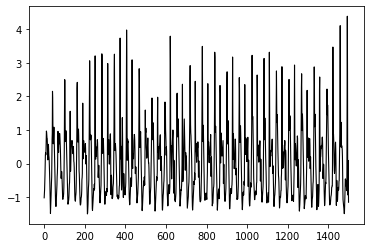

In [81]:
plt.plot(x)

In [106]:
x = np.array(data["ConsumprionMWtH"])
mean = x.mean()
std = x.std()
x = MakeStationary((x - mean) / std)

In [107]:
H = HankelMatrix(x[6000:], L=200)

pca = PCA(n_components=3)
x_3d = pca.fit_transform(H)

center_3d = x_3d.mean(axis=0)
x_3d_centered = x_3d - center_3d

Text(0.5, 0, '3rd eigenvector')

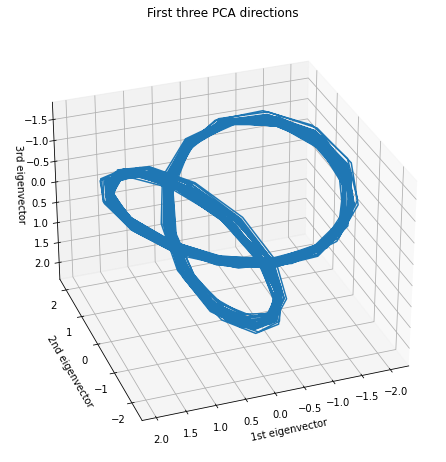

In [23]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:800, 2], x_3d[:800, 1], x_3d[:800, 0])

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# plt.savefig('pictures/energy_cons_init_3d_traj.eps', bbox_inches='tight')

### 3D

In [112]:
pred_X = ApplyDR(TrajectoryToSpherical(x_3d_centered), 2)

In [113]:
pred_X

array([[1.37679043, 3.28037404],
       [1.80735547, 3.08285245],
       [2.12669723, 2.65246243],
       ...,
       [1.85127566, 5.36625146],
       [1.6942017 , 5.83467999],
       [1.38587585, 6.13438929]])

In [114]:
spherical_tr = TrajectoryToSpherical(x_3d_centered)
spherical_tr[:, -1]

array([2.04781221, 2.07270517, 2.14137533, ..., 2.49128657, 2.44987438,
       2.39101145])

In [115]:
w_dr[0]

array([-0.00764826,  0.01072056, -0.00373307,  2.38853733])

In [116]:
spherical_tr = TrajectoryToSpherical(x_3d_centered)
w_init = np.linalg.lstsq(add_free(spherical_tr[:, :-1]), spherical_tr[:, -1])
y_pred_init = add_free(spherical_tr[:, :-1]).dot(w_init[0])

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/Users/denistikhonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/Users/denistikhonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


In [117]:
dr_trajectory

array([[-0.28159179, -2.10348938,  0.03905761],
       [-1.14278896, -1.83767619,  0.48675327],
       [-1.65319667, -1.17159369,  1.02676985],
       ...,
       [-1.72797978,  0.68614918, -1.46767768],
       [-1.53542633,  1.42317755, -1.0852444 ],
       [-0.964575  ,  1.98010109, -0.66040906]])

In [118]:
y_pred_dr, y_pred_init

(array([2.12261325, 2.21809583, 2.27155174, ..., 2.36871116, 2.35811869,
        2.29942283]),
 array([2.12261325, 2.21809583, 2.27155174, ..., 2.36871116, 2.35811869,
        2.29942283]))

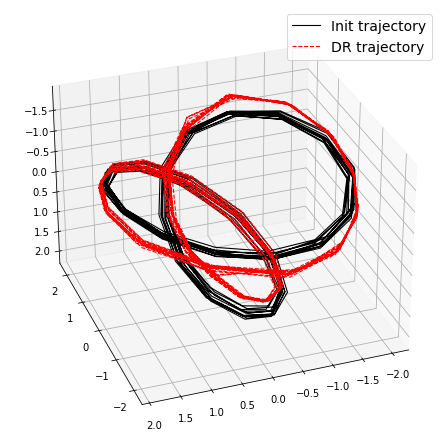

In [119]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d_centered[:300, 2], x_3d_centered[:300, 1], x_3d_centered[:300, 0], label="Init trajectory")
ax.plot3D(dr_trajectory[:300, 2], dr_trajectory[:300, 1], dr_trajectory[:300, 0], label="DR trajectory", c='r')
ax.legend(fontsize=14)

# plt.savefig('pictures/energy_cons_predicted_vs_init.eps', bbox_inches='tight')

### 4D

In [108]:
pca = PCA(n_components=4)
x_4d = pca.fit_transform(H)

center_4d = x_4d.mean(axis=0)
x_4d_centered = x_4d - center_4d

In [109]:
r = 3
pred_X = ApplyDR(TrajectoryToSpherical(x_4d_centered), r=r)

In [110]:
spherical_tr = TrajectoryToSpherical(x_4d_centered)

w_init = np.linalg.lstsq(add_free(spherical_tr[:, :-1]), spherical_tr[:, -1])
y_pred_init = add_free(spherical_tr[:, :-1]).dot(w_init[0])

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/Users/denistikhonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/denistikhonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [111]:
dr_trajectory

array([[-0.29820191, -2.22756682,  0.04136149, -0.8705849 ],
       [-1.17571623, -1.89062531,  0.50077813, -0.79708685],
       [-1.71859033, -1.21793711,  1.06738464, -0.55595758],
       ...,
       [-1.76035169,  0.69900347, -1.4951731 ,  0.02150422],
       [-1.55490488,  1.4412321 , -1.0990119 , -0.39548818],
       [-0.97873435,  2.00916772, -0.67010345, -0.66521171]])

In [31]:
pca = PCA(n_components=3)
dr_trajectory_3d = pca.fit_transform(dr_trajectory)

In [32]:
# %matplotlib notebook

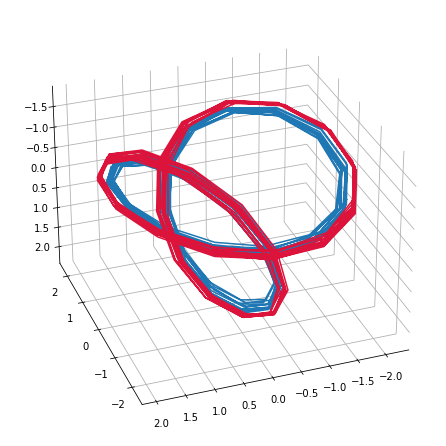

In [33]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d_centered[:300, 2], x_3d_centered[:300, 1], x_3d_centered[:300, 0], label="Init")
ax.plot3D(dr_trajectory[:300, 2], dr_trajectory[:300, 1], dr_trajectory[:300, 0], label="Predicted", c='crimson')

# ax.legend(fontsize=14)

# ax.set_title("Потребление электроэнергии", size=16)
ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# plt.savefig('pictures/energy_cons_predicted_vs_init_no_title.eps', bbox_inches='tight')

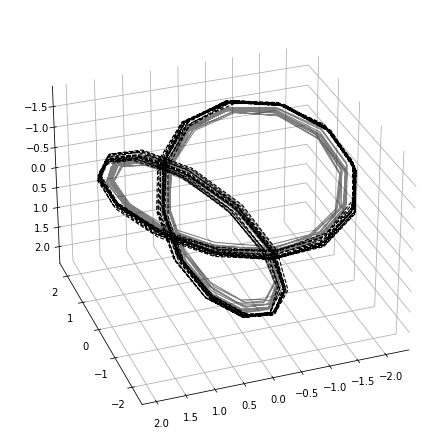

In [34]:
init_colors = plt.rcParams['axes.prop_cycle']
plt.rcParams['axes.prop_cycle'] = monochrome

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d_centered[:300, 2], x_3d_centered[:300, 1], x_3d_centered[:300, 0], label="Init", alpha=0.5)
ax.plot3D(dr_trajectory[:300, 2], dr_trajectory[:300, 1], dr_trajectory[:300, 0], label="Predicted")

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.rcParams['axes.prop_cycle'] = init_colors

# plt.savefig('pictures/energy_cons_predicted_vs_init_no_title_monochrome.jpg', bbox_inches='tight')

### Energy consumption -- 2

In [35]:
# data = pd.read_excel('GermanWeather.xls', header=None)

In [36]:
data = pd.read_csv('data/TurkElectricityConsumption.csv', header=None)

In [37]:
x = np.array(data[6])

mean = x.mean()
std = x.std()
x = MakeStationary((x - mean) / std)

H = HankelMatrix(x[400:1500], L=170)

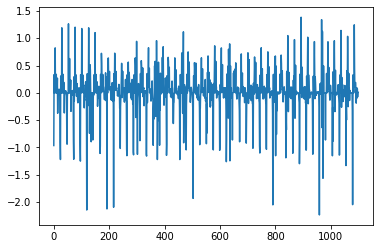

In [38]:
plt.plot(x[400:1500])

In [39]:
pca = PCA(n_components=3)
x_3d = pca.fit_transform(H)

Text(0.5, 0, '3rd eigenvector')

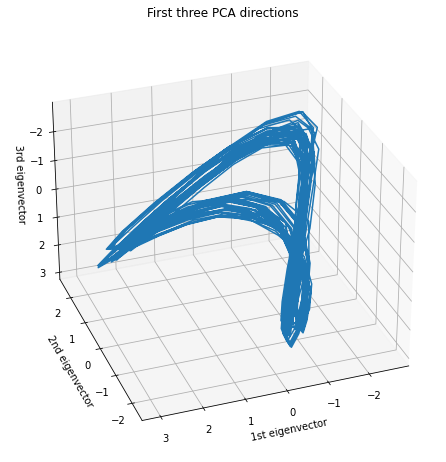

In [40]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2])

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# plt.savefig('pictures/energy_cons_init_3d_traj.eps', bbox_inches='tight')

In [41]:
pca = PCA(n_components=4, random_state=1)
x_4d = pca.fit_transform(H)

In [42]:
r = 3
pred_X = ApplyDR(TrajectoryToSpherical(x_4d), r=r, h=20)

In [43]:
spherical_tr = TrajectoryToSpherical(x_4d)

w_init = np.linalg.lstsq(add_free(spherical_tr[:, :-1]), spherical_tr[:, -1])
y_pred_init = add_free(spherical_tr[:, :-1]).dot(w_init[0])

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/Users/denistikhonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/denistikhonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


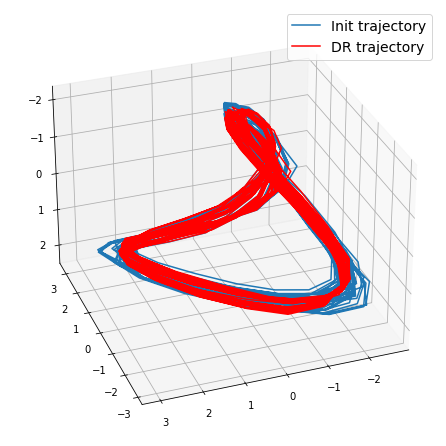

In [44]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 2], x_3d[:, 1], label="Init trajectory")
ax.plot3D(dr_trajectory[:, 0], dr_trajectory[:, 2], dr_trajectory[:, 1], label="DR trajectory", c='r')
ax.legend(fontsize=14)

# plt.savefig('pictures/energy_cons_2_predicted_vs_init.eps', bbox_inches='tight')

### Accelerometer walking

In [52]:
mat_wlk = scipy.io.loadmat('data/acc_wlk.mat')['sensor_readings'][:, 0]
scaler = StandardScaler()
x = scaler.fit_transform(mat_wlk[:, np.newaxis])
H = HankelMatrix(x, L=200)

In [53]:
pca = PCA(n_components=3, random_state=1)
x_3d = pca.fit_transform(H)

In [88]:
r = 2
pred_X = ApplyDR(TrajectoryToSpherical(x_3d), r=r, h=20)
pred_X

array([[-2.64624798,  0.04329032],
       [-2.42744914,  0.14527627],
       [-2.12438953,  0.21308019],
       ...,
       [-5.87352875,  0.94854598],
       [-5.91747605,  0.74697547],
       [-5.98298011,  0.5610591 ]])

In [89]:
spherical_tr = TrajectoryToSpherical(x_3d)

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/Users/denistikhonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
y_pred_dr

array([10.98565566, 10.99052115, 10.99834106, ..., 10.87844107,
       10.88012789, 10.88095722])

In [56]:
# %matplotlib notebook

In [91]:
dr_trajectory

array([[ 8.21237713, -6.03603825,  4.09972368],
       [ 9.28048211, -4.20036437,  4.12566915],
       [10.07575795, -2.20630742,  3.81769766],
       ...,
       [ 7.6058596 ,  7.20207302, -2.93624319],
       [ 5.85828129,  8.43182112, -3.60029384],
       [ 3.95154158,  9.35812988, -3.89948129]])

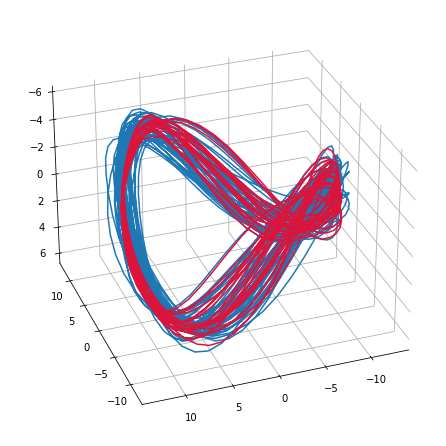

In [57]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], label="Init")
ax.plot3D(dr_trajectory[:1000, 0], dr_trajectory[:1000, 1], dr_trajectory[:1000, 2], 
          label="Predicted", c='crimson')
# ax.set_title("Акселерометр, ходьба", size=16)
# ax.legend(fontsize=14)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# plt.savefig('pictures/accelerometer_predicted_vs_init_no_title.eps', bbox_inches='tight')

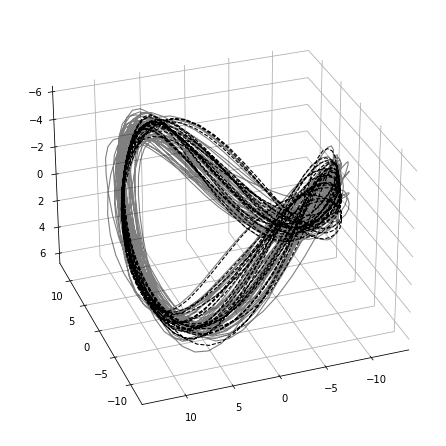

In [58]:
init_colors = plt.rcParams['axes.prop_cycle']
plt.rcParams['axes.prop_cycle'] = monochrome

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], label="Init", alpha=0.5)
ax.plot3D(dr_trajectory[:1000, 0], dr_trajectory[:1000, 1], dr_trajectory[:1000, 2], label="Predicted")
# ax.set_title("Акселерометр, ходьба", size=16)
# ax.legend(fontsize=14)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.rcParams['axes.prop_cycle'] = init_colors

# plt.savefig('pictures/accelerometer_predicted_vs_init_no_title_monochrome.jpg', bbox_inches='tight')

### Accelerometer running

In [59]:
mat_wlk = scipy.io.loadmat('data/acc_run.mat')['sensor_readings'][:, 0]
scaler = StandardScaler()
x = scaler.fit_transform(mat_wlk[:, np.newaxis])
H = HankelMatrix(x, L=200)

In [60]:
pca = PCA(n_components=3, random_state=1)
x_3d = pca.fit_transform(H)

In [61]:
r = 2
pred_X = ApplyDR(TrajectoryToSpherical(x_3d), r=r, h=20)

In [62]:
spherical_tr = TrajectoryToSpherical(x_3d)

w_dr = np.linalg.lstsq(add_free(pred_X), spherical_tr[:, -1])
y_pred_dr = add_free(pred_X).dot(w_dr[0])

dr_trajectory = spherical_tr
dr_trajectory[:, -1] = y_pred_dr
dr_trajectory = TrajectoryToCartesian(dr_trajectory)

/Users/denistikhonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
# %matplotlib notebook

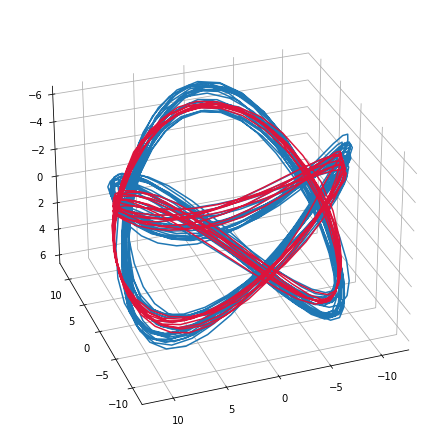

In [64]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], label="Init")
ax.plot3D(dr_trajectory[:500, 0], dr_trajectory[:500, 1], dr_trajectory[:500, 2], label="Predicted", c='crimson')

# ax.legend(fontsize=14)

# ax.set_title("Акселерометр, бег", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# plt.savefig('pictures/accelerometer_run_predicted_vs_init_no_title.eps', bbox_inches='tight')

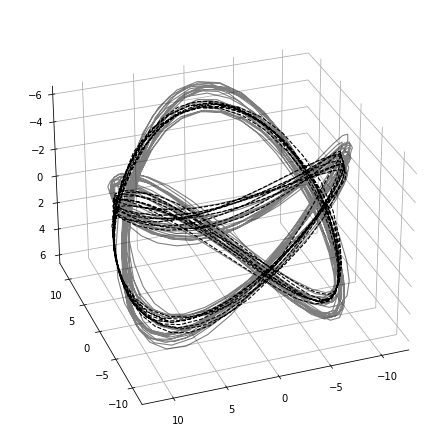

In [65]:
init_colors = plt.rcParams['axes.prop_cycle']
plt.rcParams['axes.prop_cycle'] = monochrome

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], label="Init", alpha=0.5)
ax.plot3D(dr_trajectory[:500, 0], dr_trajectory[:500, 1], dr_trajectory[:500, 2], label="Predicted")

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.rcParams['axes.prop_cycle'] = init_colors

# plt.savefig('pictures/accelerometer_run_predicted_vs_init_no_title_monochrome.jpg', bbox_inches='tight')

### Find dimensionality

In [66]:
def CompMse(cart_tr, spherical_tr):
    n_components = cart_tr.shape[1]
    mse_list = []
    for r in range(1, n_components):
        pred_angles = ApplyDR(spherical_tr, r, h=20)

        m = int(pred_angles.shape[0])
        w_dr = np.linalg.lstsq(add_free(pred_angles[:m // 2]), spherical_tr[:m // 2, -1])
        y_pred_dr = add_free(pred_angles[m // 2:]).dot(w_dr[0])

        pred_trajectory = spherical_tr[m // 2:].copy()
        pred_trajectory[:, -1] = y_pred_dr
        pred_trajectory = TrajectoryToCartesian(pred_trajectory)

        mse = np.mean((cart_tr[m // 2:] - pred_trajectory) ** 2)
        mse_list.append(mse)
    return np.array(mse_list)

In [67]:
# accelerometer_wlk
# accelerometer_run
# energy
# energy_2

data_name = "accelerometer_run"
picture_filename = 'pictures/mse.eps'

In [68]:
if data_name == 'accelerometer_wlk':
    mat_wlk = scipy.io.loadmat('USC-HAD/Subject1/a1t1.mat')['sensor_readings'][:, 0]
    scaler = StandardScaler()
    x = scaler.fit_transform(mat_wlk[:, np.newaxis])
    H = HankelMatrix(x, L=200)
    picture_filename = 'pictures/accelerometer_mse'
    seed = 42
    title = 'Акселерометр, ходьба'
    # h = 30, seed = 42
elif data_name == 'accelerometer_run':
    mat_run = scipy.io.loadmat('USC-HAD/Subject1/a6t1.mat')['sensor_readings'][:, 0]
    scaler = StandardScaler()
    x = scaler.fit_transform(mat_run[:, np.newaxis])
    H = HankelMatrix(x, L=200)
    picture_filename = 'pictures/accelerometer_run_mse'
    seed = 6
    title = 'Акселерометр, бег'
    # h = 20, seed = 6
elif data_name == 'energy':
    data = pd.read_csv('EnergyConsumption.csv').iloc[:, 3:]
    x = np.array(data["ConsumprionMWtH"])
    mean = x.mean()
    std = x.std()
    x = MakeStationary((x - mean) / std)
    H = HankelMatrix(x[6000:], L=200)
    picture_filename = 'pictures/energy_mse'
    seed = 42
    title = 'Потребление электроэнергии'
    # h = 30, seed = 42
elif data_name == 'energy_2':
    data = pd.read_csv('TurkElectricityConsumption.csv', header=None)
    x = np.array(data[6])
    mean = x.mean()
    std = x.std()
    x = MakeStationary((x - mean) / std)
    H = HankelMatrix(x[400:1500], L=170)
    picture_filename = 'pictures/energy_2_mse'
    seed = 42
    title = ""
else:
    N = 4000
    t_max = 400
    np.random.seed(42)
    # sin(x) + 0.8 * sin(x / 2) + 0.3N(0, 1)
    x = np.sin(np.linspace(0, t_max, N + 1)) + 2 * np.sin(np.linspace(0, t_max, N + 1) / 2) * 0.4 + \
        np.random.randn(N + 1) * 0.3
    H = HankelMatrix(x, L=200)
    picture_filename = 'pictures/gen_mse'
    seed = 42
    title = ""
    
print(data_name)
print(picture_filename)
print(title)

FileNotFoundError: [Errno 2] No such file or directory: 'USC-HAD/Subject1/a6t1.mat'

In [83]:
n_components = 15
pca = PCA(n_components=n_components, random_state=1)
x_tr = pca.fit_transform(H)

center = x_tr.mean(axis=0)
x_centered = x_tr - center
spherical_tr = TrajectoryToSpherical(x_centered)

In [84]:
mse = CompMse(x_centered, spherical_tr)
mse, picture_filename

/Users/denistikhonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


(array([0.04499919, 0.04496211, 0.04489636, 0.04491675, 0.04497326,
        0.04489116, 0.04488015, 0.04499764, 0.04494874, 0.04473299,
        0.04479847, 0.04479609, 0.04459755, 0.04441111]),
 'pictures/mse.eps')

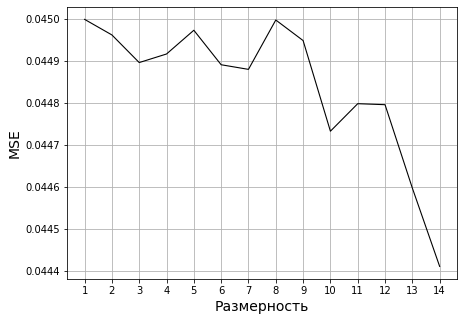

In [85]:
init_colors = plt.rcParams['axes.prop_cycle']
plt.rcParams['axes.prop_cycle'] = monochrome

plt.figure(figsize=(7, 5))
plt.plot(list(range(1, n_components)), mse)
plt.grid()
plt.xticks(range(1, n_components))
plt.xlabel("Размерность", size=14)
plt.ylabel("MSE", size=14)

plt.rcParams['axes.prop_cycle'] = init_colors

# plt.savefig(picture_filename + '_no_title_monochrome.eps', bbox_inches='tight')